In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from scipy.stats import zscore
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/MahalanobisAD_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

def get_section_types(wav_names):
    section_types = []
    for wav_name in wav_names:
        if 'section_00' in wav_name:
            section_types.append(0)
        elif 'section_01' in wav_name:
            section_types.append(1)
        else:
            section_types.append(2)
    
    return section_types

section_types = get_section_types(wav_names)

# evaluation

## calc MVG (multivariate Gaussian)

In [10]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    
    mean = ext_data['train']['features'].mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(ext_data['train']['features'])
    cov = cov_estimator.covariance_
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 27.987079859 [sec]


In [11]:
MVG[machine_type]['cov'].shape

(3072, 3072)

## estimate

2021-04-10 19:33:09,977 - 00_train.py - INFO - fan valid_source AUC : 0.5919777777777778
2021-04-10 19:33:09,979 - 00_train.py - INFO - fan valid_target AUC : 0.6142666666666666


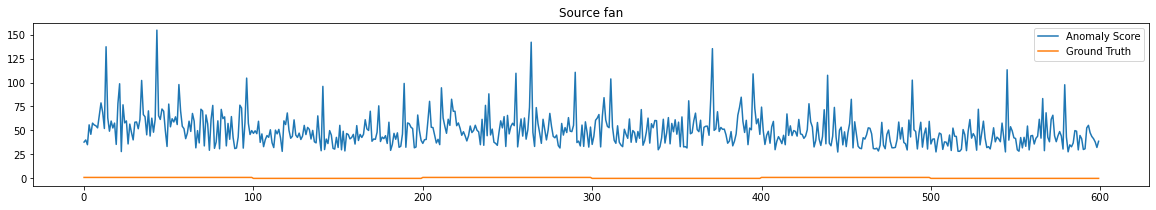

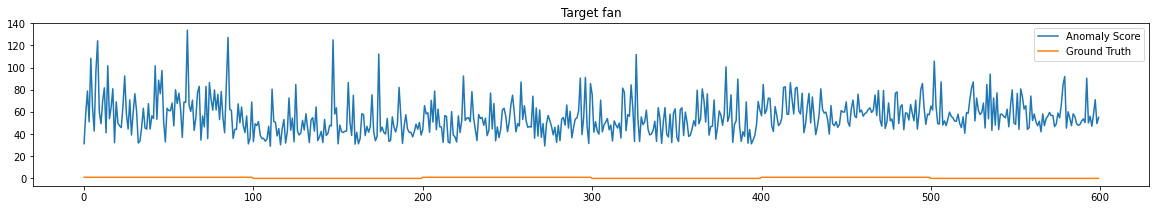

2021-04-10 19:33:13,744 - 00_train.py - INFO - gearbox valid_source AUC : 0.7237437699724804
2021-04-10 19:33:13,746 - 00_train.py - INFO - gearbox valid_target AUC : 0.7878525196486362


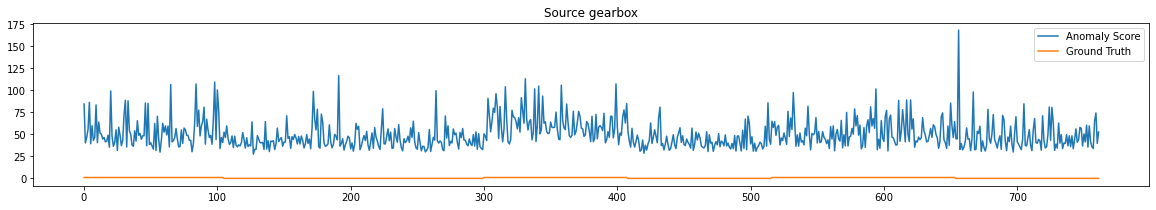

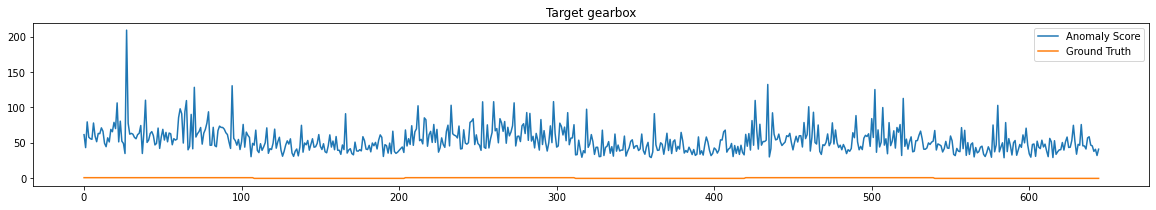

2021-04-10 19:33:17,087 - 00_train.py - INFO - pump valid_source AUC : 0.6335888888888889
2021-04-10 19:33:17,089 - 00_train.py - INFO - pump valid_target AUC : 0.5335222222222222


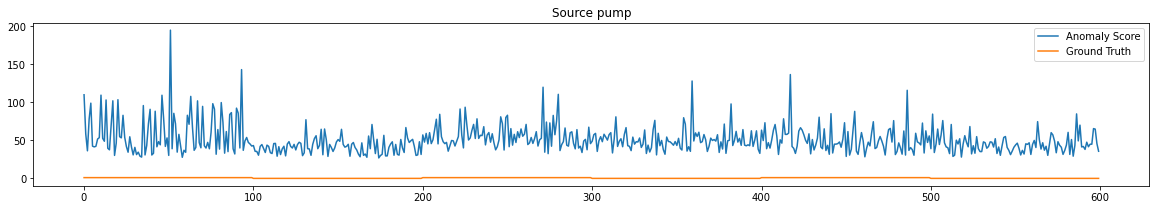

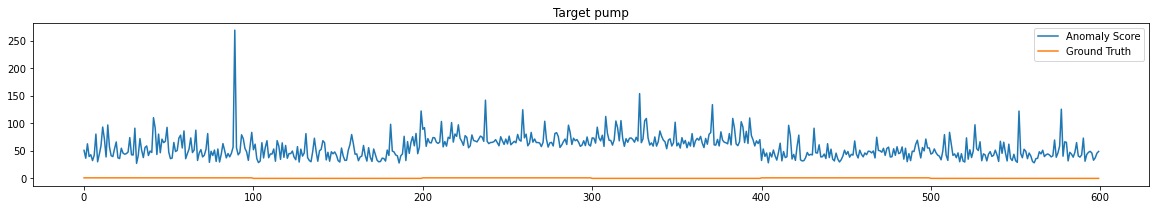

2021-04-10 19:33:20,263 - 00_train.py - INFO - slider valid_source AUC : 0.6852702414014099
2021-04-10 19:33:20,265 - 00_train.py - INFO - slider valid_target AUC : 0.6275496688741722


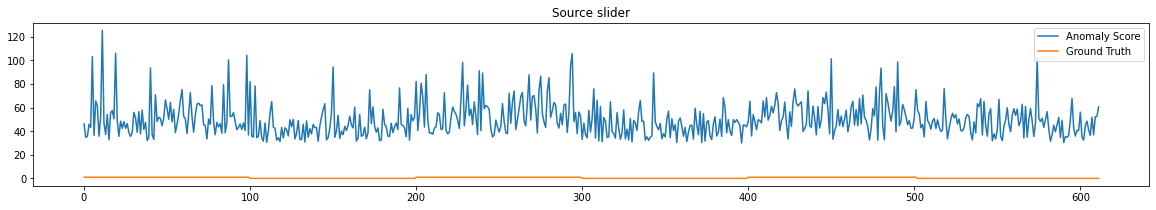

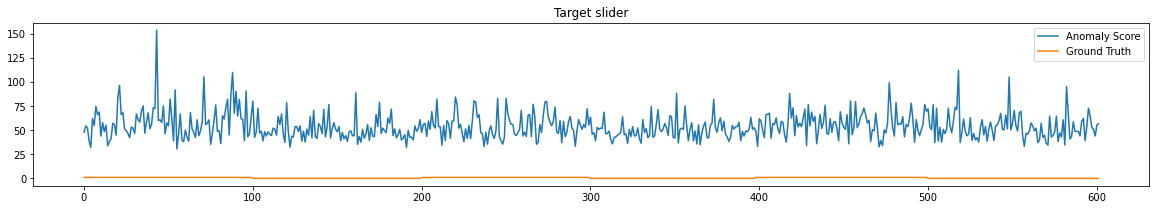

2021-04-10 19:33:23,600 - 00_train.py - INFO - ToyCar valid_source AUC : 0.6548222222222222
2021-04-10 19:33:23,603 - 00_train.py - INFO - ToyCar valid_target AUC : 0.5472111111111111


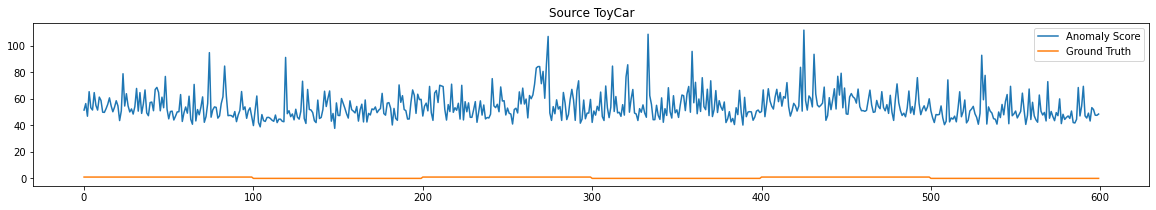

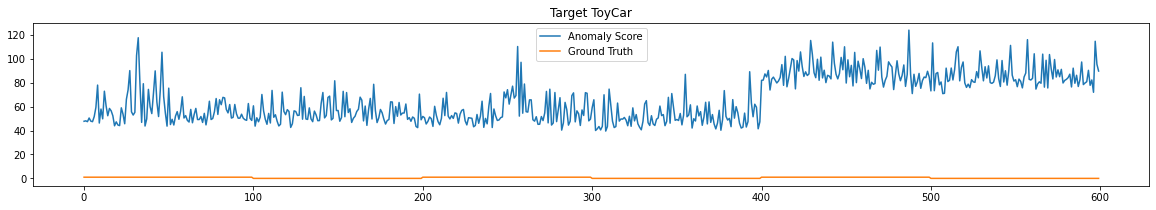

2021-04-10 19:33:27,005 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.6555888888888889
2021-04-10 19:33:27,008 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.6009


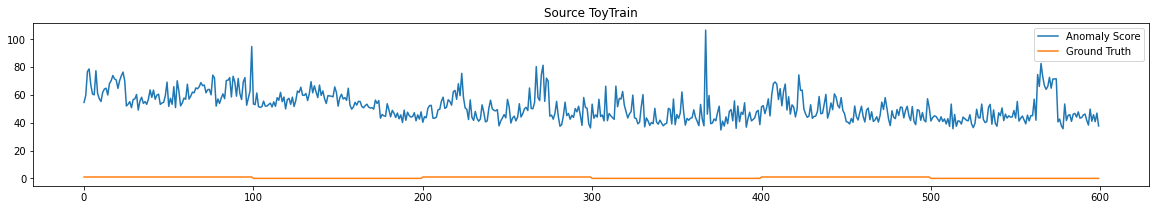

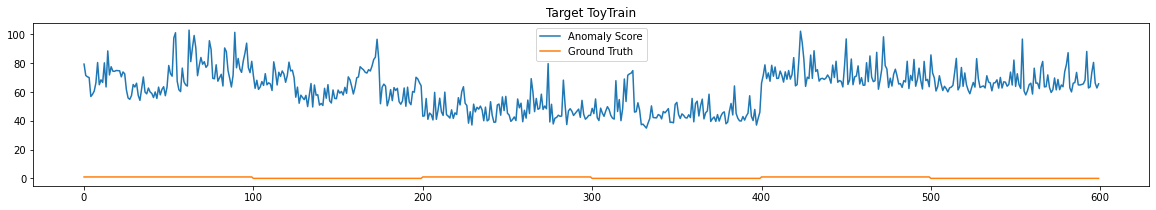

2021-04-10 19:33:30,344 - 00_train.py - INFO - valve valid_source AUC : 0.5647
2021-04-10 19:33:30,346 - 00_train.py - INFO - valve valid_target AUC : 0.5398666666666667


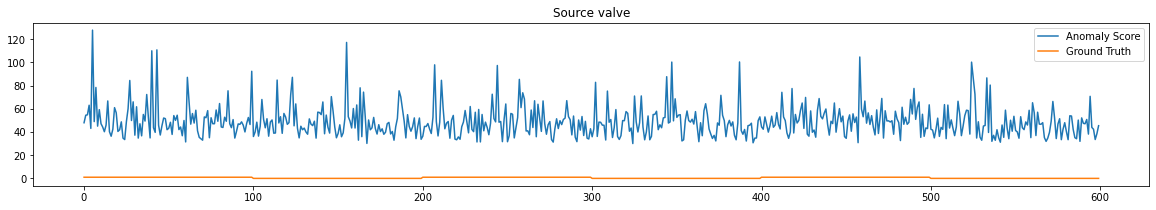

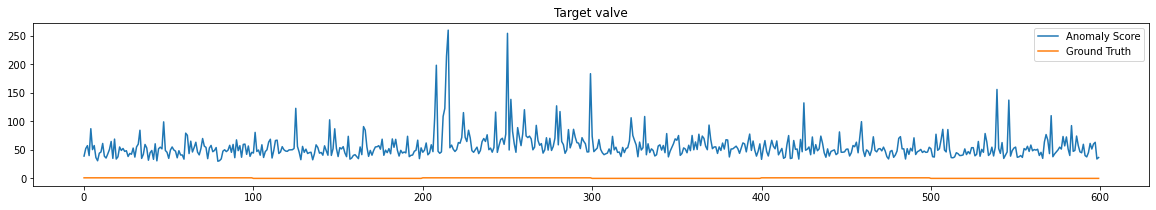

In [12]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

# UMAP

In [10]:
from umap import UMAP

In [14]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    feats = ext_data['train']['features']
    mapper = UMAP(n_components=2, random_state=42, n_neighbors=15)
    embedding = mapper.fit_transform(feats)
    
    mean = embedding.mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(embedding)
    cov = cov_estimator.covariance_
    MVG[machine_type]['mapper'] = mapper
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 105.124689817 [sec]


2021-04-11 22:53:18,411 - 00_train.py - INFO - fan valid_source AUC : 0.5122222222222221
2021-04-11 22:53:18,413 - 00_train.py - INFO - fan valid_target AUC : 0.534988888888889


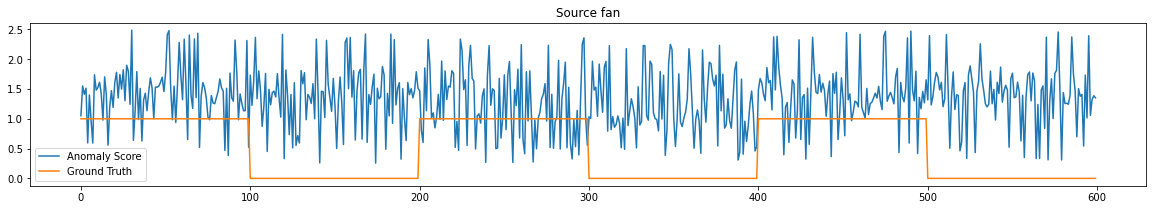

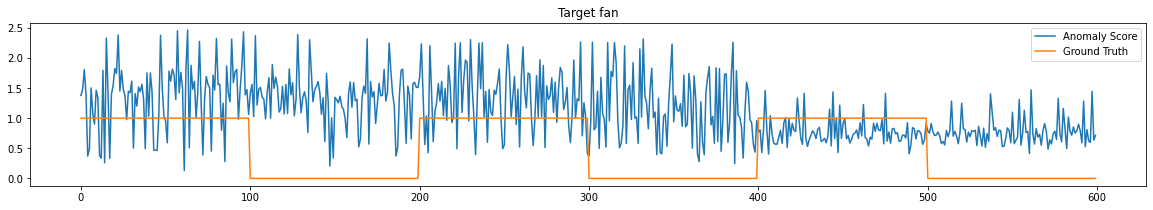

2021-04-11 22:53:24,572 - 00_train.py - INFO - gearbox valid_source AUC : 0.5191562515163489
2021-04-11 22:53:24,574 - 00_train.py - INFO - gearbox valid_target AUC : 0.5053166897827092


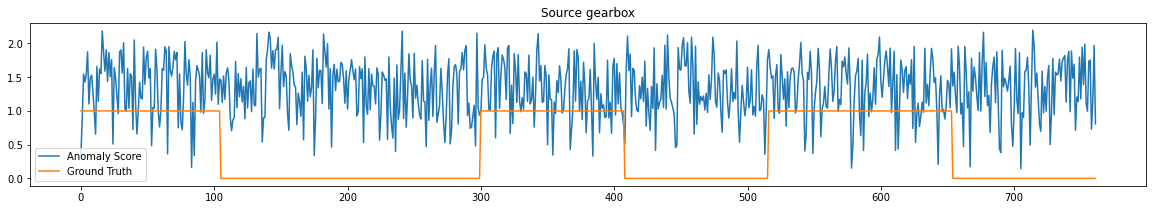

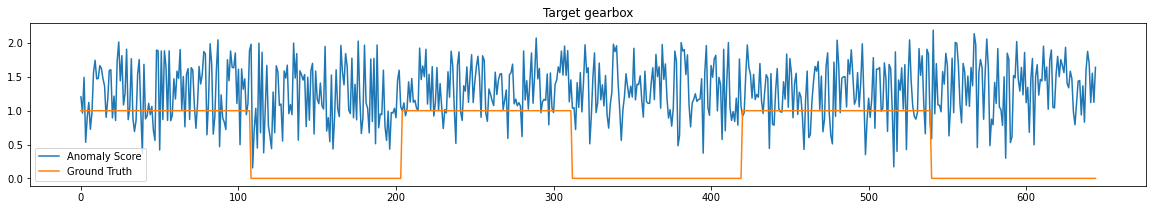

2021-04-11 22:53:30,197 - 00_train.py - INFO - pump valid_source AUC : 0.45431111111111105
2021-04-11 22:53:30,199 - 00_train.py - INFO - pump valid_target AUC : 0.5415888888888889


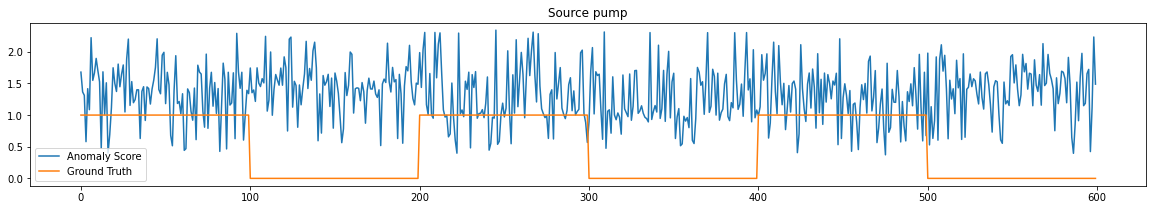

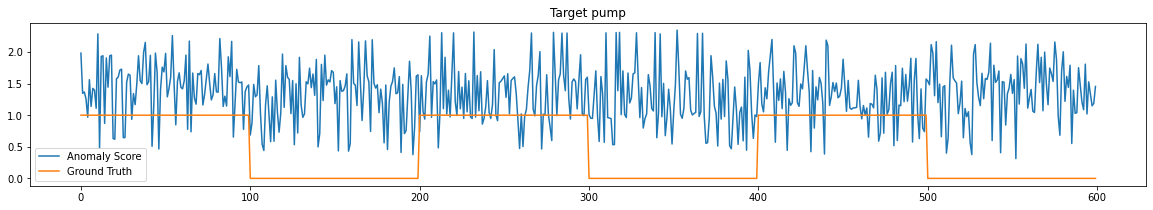

2021-04-11 22:53:36,042 - 00_train.py - INFO - slider valid_source AUC : 0.49894253364665664
2021-04-11 22:53:36,045 - 00_train.py - INFO - slider valid_target AUC : 0.5243929359823399


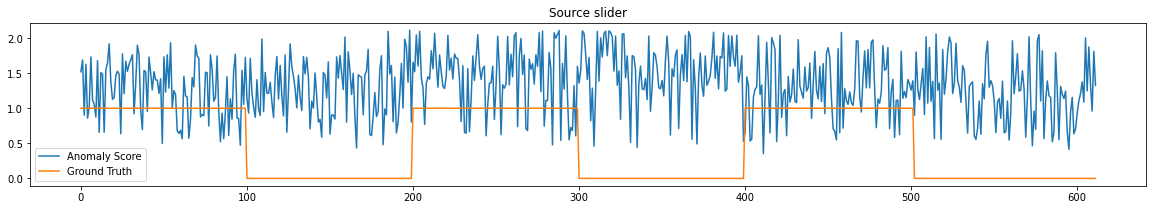

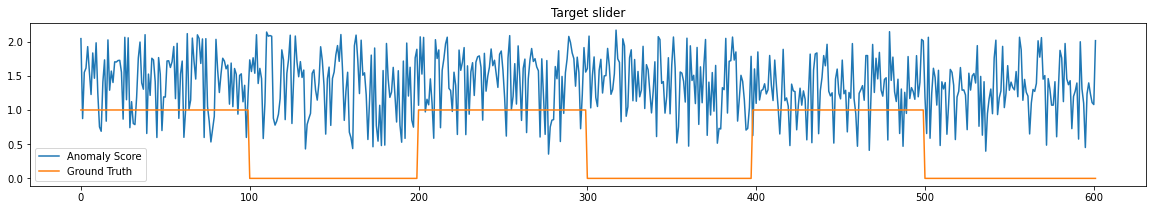

2021-04-11 22:53:41,063 - 00_train.py - INFO - ToyCar valid_source AUC : 0.48247777777777784
2021-04-11 22:53:41,065 - 00_train.py - INFO - ToyCar valid_target AUC : 0.49268888888888895


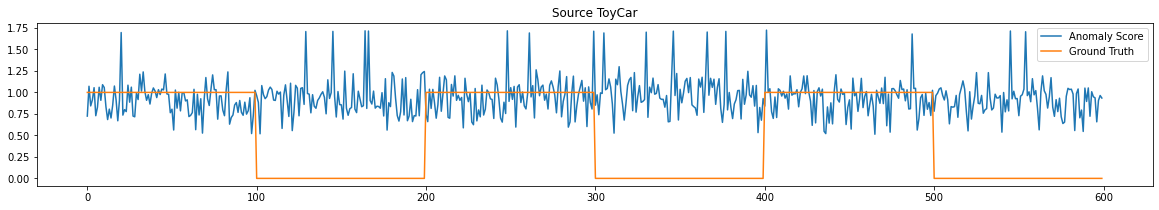

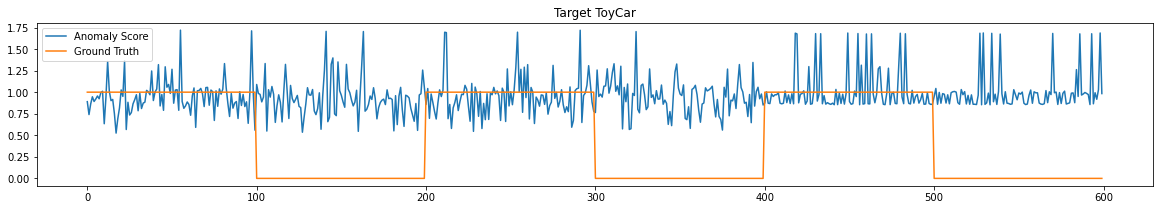

2021-04-11 22:53:46,480 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.5755444444444444
2021-04-11 22:53:46,482 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.5536999999999999


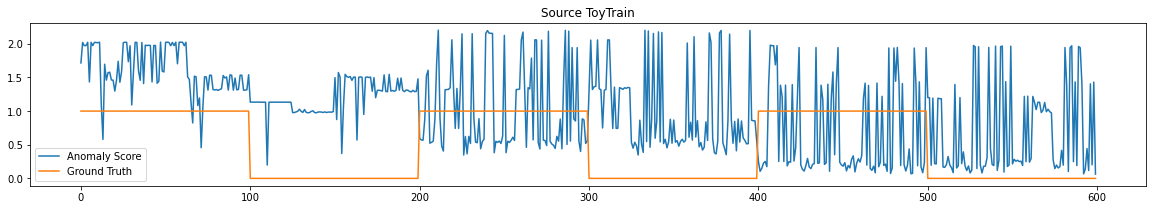

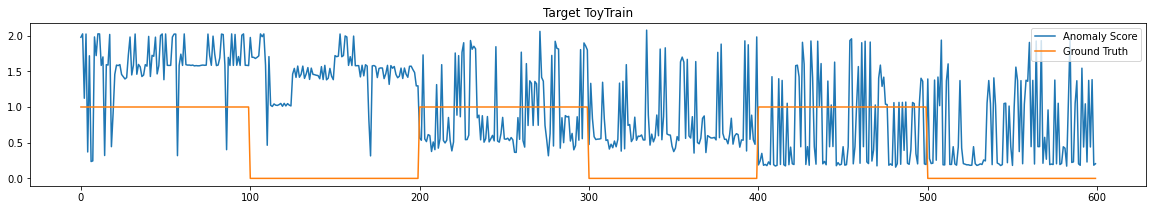

2021-04-11 22:53:52,057 - 00_train.py - INFO - valve valid_source AUC : 0.48065555555555556
2021-04-11 22:53:52,059 - 00_train.py - INFO - valve valid_target AUC : 0.5015333333333333


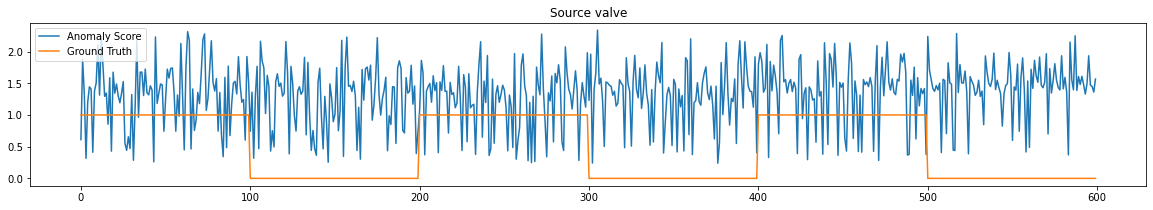

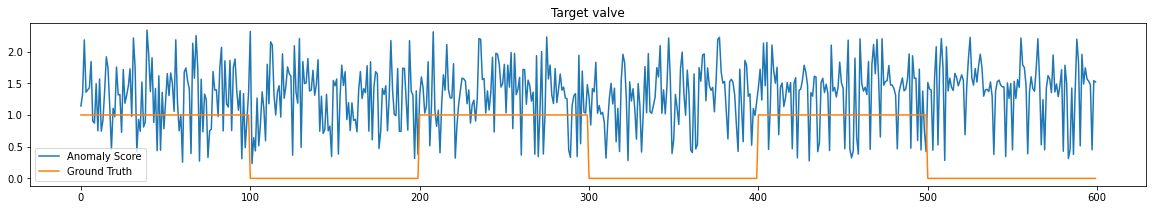

In [15]:
for machine_type in machine_types:
    # get MVG
    mapper = MVG[machine_type]['mapper']
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    source_feats = ext_data['valid_source']['features']
    source_feats = mapper.transform(source_feats)
    target_feats = ext_data['valid_target']['features']
    target_feats = mapper.transform(target_feats)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in source_feats]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in target_feats]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## Classifier Approach

In [25]:
import torch
from pytorch_model import ResNet38 as Model

In [16]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

In [26]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # model out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    logger.info('INFERENCE')
    # parameter setting
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'],
                classes_num=6
                )
    # load pre-trained model
    model_dict = torch.load(f'{MODEL_DIR}/{machine_type}_model.pth')
    net.load_state_dict(model_dict)
    # training
    output_dicts = modeler.inference_net(net, dataloaders_dict)
    
    com.toc()

In [27]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-04-11 23:03:11,569 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-04-11 23:03:11,570 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-11 23:03:11,571 - 00_train.py - INFO - TRAINING


NameError: name 'pretrained_dict' is not defined

In [20]:
machine_type = 'ToyCar'
model_dict = torch.load(f'{MODEL_DIR}/{machine_type}_model.pth')